In [ ]:
!pip install mendelai-brat-parser

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from google.colab import files
import zipfile
import tarfile
import glob

import regex as re

import xml.etree.ElementTree as ET

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from brat_parser import get_entities_relations_attributes_groups

import gensim
import gensim.downloader as api

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, Input
import tensorflow as tf

# **Dataset import**

In [ ]:
# Import the rotten imdb dataset.

uploaded = files.upload()

Saving rotten_imdb.tar.gz to rotten_imdb.tar.gz


In [ ]:
# Import the arg-microtexts dataset.

uploaded = files.upload()

Saving arg-microtexts-master.zip to arg-microtexts-master.zip


In [ ]:
# Function to extract zip file.
# Takes in input the path to the zip file (path_zip) and the one to store the destination directory (path_destination).

def extract_zip(path_zip,path_destination):
  with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(path_destination)

In [ ]:
# Extract zip file.

extract_zip('arg-microtexts-master.zip','arg-microtexts-master')

# **Extract argumentative sections and their relations**

In [ ]:
# Extract the list of xml files containing the argumentative sections in the 
# dataset and their relations.

xml_files = sorted(glob.glob("arg-microtexts-master/arg-microtexts-master/corpus/en/micro_*.xml"))

In [ ]:
# List of xml files of the essays.
xml_files[0:5]

['arg-microtexts-master/arg-microtexts-master/corpus/en/micro_b001.xml',
 'arg-microtexts-master/arg-microtexts-master/corpus/en/micro_b002.xml',
 'arg-microtexts-master/arg-microtexts-master/corpus/en/micro_b003.xml',
 'arg-microtexts-master/arg-microtexts-master/corpus/en/micro_b004.xml',
 'arg-microtexts-master/arg-microtexts-master/corpus/en/micro_b005.xml']

In [ ]:
# Transform each xml file into the xml tree representation.

list_xml_tree_representation=[ET.parse(xml_file) for xml_file in xml_files]

# Than extract from each tree its root.

list_xml_root=[tree.getroot() for tree in list_xml_tree_representation]

In [ ]:
for i in range(5):
  print(list_xml_root[i].tag)

arggraph
arggraph
arggraph
arggraph
arggraph


In [ ]:
# list_argumentative_sections will contain the lists, for each document in the
# corpus, of its argumentative sections.
list_argumentative_sections=[]
# list_arg_section_id_in_document will contain the lists, for each document in
# the corpus, of the id that identify the sections inside the document.
list_arg_section_id_in_document=[]


for root_id in range(len(list_xml_root)):
  temp_list_argumentative_sections=[]
  temp_list_arg_section_id_in_document=[]
  new_temp_list_arg_section_id_in_document=[]
  for child in list_xml_root[root_id]:
    # The nodes tagged with 'edu' contains the text of the arg. section and an unique identifier in the document.
    if child.tag=='edu':
      temp_list_argumentative_sections.append(child.text)
      temp_list_arg_section_id_in_document.append(child.get('id'))
    # In the 'edge' nodes the original id of the sections (in src) are sobstitute with new ones (in trg).
    if (child.tag=='edge'):
      src=child.get('src')
      trg=child.get('trg')
      if src in temp_list_arg_section_id_in_document:
        new_temp_list_arg_section_id_in_document.append(trg)   

  list_argumentative_sections.append(temp_list_argumentative_sections)
  list_arg_section_id_in_document.append(new_temp_list_arg_section_id_in_document)

In [ ]:
for i in range(len(list_argumentative_sections[0])):
  print("section {} in document {}: {}".format(list_arg_section_id_in_document[0][i],0,list_argumentative_sections[0][i]))

section a1 in document 0: Yes, it's annoying and cumbersome to separate your rubbish properly all the time.
section a2 in document 0: Three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins.
section a3 in document 0: But still Germany produces way too much rubbish
section a4 in document 0: and too many resources are lost when what actually should be separated and recycled is burnt.
section a5 in document 0: We Berliners should take the chance and become pioneers in waste separation!


# **Extract sentences**

In [ ]:
# All the argumentative sections are contained in a single sentence.

# Get the list of all the sentences.

M_sentence_list=[]

for i in range(len(list_argumentative_sections)):
  sentence=""
  for j in range(len(list_argumentative_sections[i])):

    sentence+=list_argumentative_sections[i][j]

    # An argumentative section which ends a sentence with a '.' as last character.
    if sentence[-1] in ['.','!','?']:
      M_sentence_list.append(sentence)
      sentence=""

  if not (sentence==""):  
    sentence_list.append(sentence)    

In [ ]:
M_sentence_list[:10]

["Yes, it's annoying and cumbersome to separate your rubbish properly all the time.",
 'Three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins.',
 'But still Germany produces way too much rubbishand too many resources are lost when what actually should be separated and recycled is burnt.',
 'We Berliners should take the chance and become pioneers in waste separation!',
 'One can hardly move in Friedrichshain or Neukölln these days without permanently scanning the ground for dog dirt.',
 "And when bad luck does strike and you step into one of the many 'land mines' you have to painstakingly scrape the remains off your soles.",
 'Higher fines are therefore the right measure against negligent, lazy or simply thoughtless dog owners.',
 "Of course, first they'd actually need to be caught in the act by public order officers,but once they have to dig into their pockets, their laziness will sure vanish!",
 'Health insurance companies should not cove

In [ ]:
len(M_sentence_list)

450

# **IMDB dataset training**

In [ ]:
# Extract tar.gz file
tar = tarfile.open('rotten_imdb.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [ ]:
subjective=open('plot.tok.gt9.5000',encoding='latin-1').read()
objective=open('quote.tok.gt9.5000',encoding='latin-1').read()

In [ ]:
# The two files contain 5000 sentences each which are divided by the \n character.
subjective=subjective.split('\n')
objective=objective.split('\n')

In [ ]:
# Both files have an additional void line.
subjective=subjective[:-1]
objective=objective[:-1]

In [ ]:
len(objective)

5000

In [ ]:
list_sentences=subjective+objective

In [ ]:
# The labels are 1 (subjective) for the first 5000 sentences and 0 (objective) for the 
# remaining 5000.
list_labels= [1] * 5000 + [0] * 5000

In [ ]:
list_labels[4990:5010]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Transform the sentences in the sequences of their words.
X_sub_obj=[nltk.word_tokenize(sentence) for sentence in list_sentences]

In [ ]:
Y_sub_obj=np.array(list_labels)

## **Word2vec and one-hot-encoding**

In [ ]:
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
# Load Google Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)  

In [ ]:
# Get the maximum lenght of the sentences.

text_len = [len(text) for text in X_sub_obj+M_sentence_list]
MAX_LEN_sub_obj= max(text_len)
print("Max lenght of sentences: {}".format(MAX_LEN_sub_obj))

Max lenght of sentences: 274


In [ ]:
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(X_sub_obj+M_sentence_list)
X_sentences_sub_obj = text_tokenizer.texts_to_sequences(X_sub_obj)
X_sentences_sub_obj = pad_sequences(X_sentences_sub_obj, maxlen=MAX_LEN_sub_obj, padding="pre")

In [ ]:
# Each word in the Word2vec model used is embedded trough a vector of size 300
EMBEDDING_SIZE_sub_obj = 300

# Size of the vocabulary used
VOCABULARY_SIZE_sub_obj = len(text_tokenizer.word_index) + 1

# Create an empty embedding matix
embedding_weights_sub_obj = np.zeros((VOCABULARY_SIZE_sub_obj, EMBEDDING_SIZE_sub_obj))

# Create a word to index dictionary mapping
word2id_sub_obj = text_tokenizer.word_index

# Copy vectors from word2vec model to the words present in corpus
for word, index in word2id_sub_obj.items():
    try:
        embedding_weights_sub_obj[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

Output streaming troncato alle ultime 5000 righe.
mordor
aragorn
self-destructive
working-class
amerika
mateo
akash
harbour
day-to-day
trasha
dogville
werner
chep
fett
lapd
genevieve
ancanar
affleck
amidala
johnathan
alexi
prosit
devlin
t-mon
high-profile
davey
duvall
brookdale
eastwood
ex-con
kilmer
barrillo
follow-up
paravasu
1970
wilco
gollum
krueger
modern-day
coppola
feardotcom
sang-woo
laramie
cristo
oedekerk
hayek
ecks
michell
zhao
glamour
branagh
cletis
oliveira
behan
reggio
miyazaki
naipaul
bartleby
muccino
clockstoppers
morvern
callar
bielinsky
dahmer
liman
eyre
kapur
polanski
birot
ill-conceived
seinfeld
hearst
derrida
ratliff
shainberg
co-writer
mepe
long-term
ex-wife
debby
19th-century
benito
sheldon
picard
19th
cat-and-mouse
legolas
gimli
rohan
siddalee
murdock
rip-off
24
caulfield
bettien
meeper
face-to-face
19
has-been
dead-end
cuthbertson
chubbchubbs
'i
durval
celia
state-of-the-art
in-depth
mudd
benigno
1960
marlowe
virgil
t-x
reinalda
mcconaughey
14
naboo
padm
twenty

## **RNN**

In [ ]:
# Create and train recurrent models

# Bidirectional LSTM model

def train_BLSTM(X_train:np.ndarray, Y_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_sub_obj,))

  model = Embedding(input_dim=VOCABULARY_SIZE_sub_obj, output_dim=EMBEDDING_SIZE_sub_obj, input_length=MAX_LEN_sub_obj, weights= [embedding_weights_sub_obj], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(64))(model)
  model = Dropout(0.1)(model)
  model = Dense(16, activation='relu')(model)
  output = Dense(1, activation='sigmoid')(model)

  final_model=Model(input,output)

  final_model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
    
  training_results= final_model.fit(X_train, Y_train, batch_size=64, epochs=30, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=3),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return final_model

## **Final model**

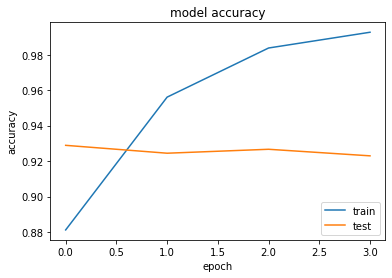

              precision    recall  f1-score   support

   Objective       0.90      0.94      0.92       477
  Subjective       0.95      0.90      0.92       523

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [ ]:
# Create the model to predict the subjectivity of sentence from the Stab and Gurevych argumentation mining dataset (2017).
# Split between test and train set.

target_names=['Objective','Subjective']

y_pred=[]
y_true=[]

X_train, X_test, Y_train, Y_test = train_test_split(X_sentences_sub_obj, Y_sub_obj, test_size=0.1, random_state=22)

model=train_BLSTM(X_train,Y_train)

# Transform probabilities predicted in the most probable value (0 or 1).
y_pred_temp=model.predict(X_test).tolist()
for input in y_pred_temp:
    y_pred.append(round(input[0]))
y_true+=Y_test.tolist()

# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names))   

## **Prediction**

In [ ]:
X = text_tokenizer.texts_to_sequences(M_sentence_list)
X = pad_sequences(X, maxlen=MAX_LEN_sub_obj, padding="pre")

In [ ]:
y_pred=[]

# Store the probabilities predicted.
y_pred_temp=model.predict(X).tolist()
for input in y_pred_temp:
    y_pred.append(round(input[0],5))

In [ ]:
len(y_pred)

450

In [ ]:
f = open("subj_obj_Microtexts.txt", "a")
for prediction in y_pred:
  f.write("{}--".format(prediction))
f.close()

In [ ]:
# Read the file
scores_text=open("subj_obj_Microtexts.txt").read()

In [ ]:
subjectivity_scores=scores_text.split('--')

In [ ]:
len(subjectivity_scores)

451

In [ ]:
subjectivity_scores[:10]

['0.00029',
 '0.9925',
 '0.00682',
 '0.44594',
 '0.03351',
 '0.20277',
 '0.21332',
 '0.22331',
 '0.0339',
 '0.05395']